# BM40A1401 GPU Computing

## Erik Kuitunen

### Exercise 3

In [127]:
import cupy as cp
import numpy as np 
import matplotlib.pyplot as plt 
import time

#### Task 1
Both NumPy and CuPy offer the linear algebra functions  linalg.norm() to get the norm and linalg.qr() to get the QR decomposition of matrices.

Time their performance against different sizes of square matrices.

Creating data and perfroming the calculations

In [128]:
N_elems = [ 10, 100, 500, 1000, 2000, 3000, 4000 ] 

times_cpu = np.zeros( ( np.size( N_elems ), 2 ) )
times_gpu = np.zeros( ( np.size( N_elems ), 2 ) )

ii = 0
for elem in N_elems:
    
    # CPU measurements
    a_cpu = np.random.randn( elem, elem )
    
    start_time = time.perf_counter()
    res = np.linalg.norm( a_cpu )
    end_time = time.perf_counter()

    times_cpu[ ii, 0 ] = ( end_time - start_time )*1000
    
    start_time = time.perf_counter()
    res = np.linalg.qr( a_cpu )
    end_time = time.perf_counter()

    times_cpu[ ii, 1 ] = ( end_time - start_time )*1000
    
    
    # GPU measurements
    a_gpu = cp.random.randn( elem, elem )
    
    start_time = time.perf_counter()
    res = cp.linalg.norm( a_gpu )
    end_time = time.perf_counter()
    
    times_gpu[ ii, 0 ] = ( end_time - start_time )*1000
    
    start_time = time.perf_counter()
    res = cp.linalg.qr( a_gpu )
    end_time = time.perf_counter()
    
    times_gpu[ ii, 1 ] = ( end_time - start_time )*1000
    
    ii += 1
    

Visualizing results

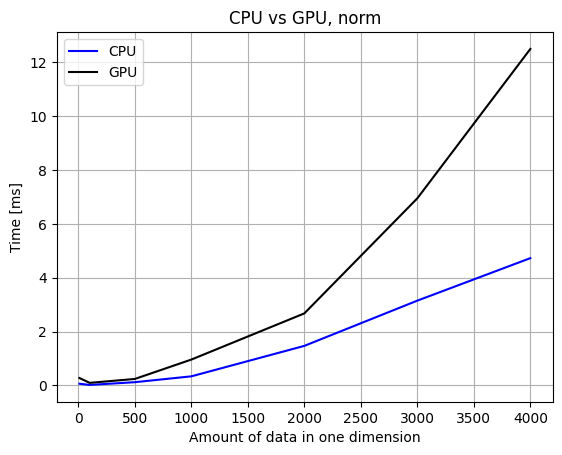

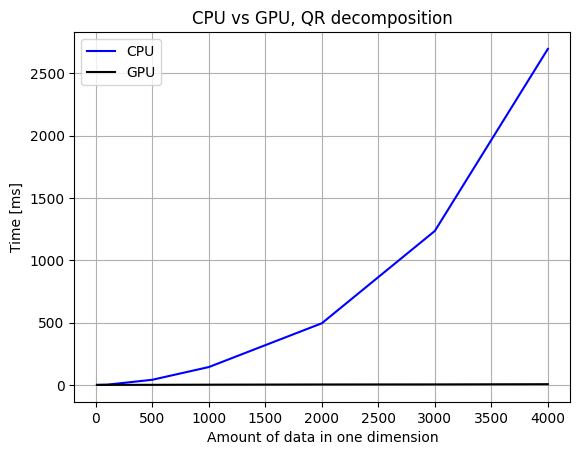

In [129]:
plt.plot( N_elems, times_cpu[ :, 0 ], 'b', label = "CPU" )
plt.plot( N_elems, times_gpu[ :, 0 ], 'k', label = "GPU")

plt.title( "CPU vs GPU, norm")
plt.xlabel( 'Amount of data in one dimension' )
plt.ylabel( 'Time [ms]' )
plt.legend( loc = "upper left" )
plt.grid()

plt.show()

plt.plot( N_elems, times_cpu[ :, 1 ], 'b', label = "CPU")
plt.plot( N_elems, times_gpu[ :, 1 ], 'k',label = "GPU")

plt.title( "CPU vs GPU, QR decomposition")
plt.xlabel( 'Amount of data in one dimension')
plt.ylabel( 'Time [ms]' )
plt.legend( loc = "upper left" )
plt.grid()

plt.show()

#### Task 2
Implement vector addition using NumPy, CuPy and an example kernel used in previous exercises. Time their performance against different vector sizes.

In [130]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

N_elems = [ 100, 10**3, 10**4, 10**5, 10**6 ] 

times_numpy = np.zeros( ( np.size( N_elems ), 1 ) )
times_cupy = np.zeros( ( np.size( N_elems ), 1 ) )
times_kernel = np.zeros( ( np.size( N_elems ), 1 ) )

The same N vector as in previous task will be used. 

Functions and kernel:

In [131]:

# NumPy vector addition
def vecAdd_numpy( a, b ):
    
    vector_length = np.size(a)
    c = np.zeros( ( vector_length, 1) )

    for ii in range( vector_length ):
        c[ ii ] = a[ii] + b[ii]
    return c

# CuPy vector addition
def vecAdd_cupy( a, b ):
    
    vector_length = cp.size(a)
    c = cp.zeros( ( vector_length, 1) )

    c = cp.add( a, b )
    
# PyCUDA vector addition
modd = SourceModule("""
  __global__ void vector_addition( double* a, double* b, double* c, int n_elem) {

    for ( int i = threadIdx.x + blockIdx.x * blockDim.x; 
          i < n_elem; 
          i += gridDim.x * blockDim.x ) {
            
        c[i] = a[i] + b[i];
    
    }
  }
""")

NumPy calculations

In [132]:
for ii in range( 100 ):
    jj = 0
    for elems in N_elems:
        
        a = np.random.randn( elems, 1 ).astype( float )
        b = np.random.randn( elems, 1 ).astype( float )
        
        # Calling NumPy function and saving result
        start_time = time.perf_counter()
        res = vecAdd_numpy( a, b )
        end_time = time.perf_counter()
        times_numpy[ jj ] += ( end_time - start_time )*1000
        
        jj += 1
        
times_numpy = times_numpy/100

CuPy calculations

In [133]:
for ii in range( 100 ):
    jj = 0
    for elems in N_elems:
        
        a = cp.random.randn( elems, 1 ).astype( float )
        b = cp.random.randn( elems, 1 ).astype( float )
        
        # Calling CuPy function and saving result
        start_time = time.perf_counter()
        res = vecAdd_cupy( a, b )
        end_time = time.perf_counter()
        times_cupy[ jj ] += ( end_time - start_time )*1000
        
        jj += 1
        
times_cupy = times_cupy/100

PyCUDA calculations

In [134]:


for ii in range( 100 ):
    jj = 0
    for elems in N_elems:
        
        a = np.random.randn( elems, 1 ).astype( float )
        b = np.random.randn( elems, 1 ).astype( float )
        
        block_dims = ( 1024, 1, 1 )
        grid_dims = ( int( np.ceil( elems / 1024 ) ), 1, 1 )
        
        a_gpu = cuda.mem_alloc( a.size * a.dtype.itemsize )
        cuda.memcpy_htod( a_gpu, a )

        b_gpu = cuda.mem_alloc( a.size * a.dtype.itemsize )
        cuda.memcpy_htod( b_gpu, b )

        c = np.empty_like(a)
        c_gpu = cuda.mem_alloc( a.size * a.dtype.itemsize )
        
        kernel = modd.get_function( "vector_addition" )
        
        start_time = time.perf_counter()
        kernel( a_gpu, b_gpu, c_gpu, np.int32( elems ), block = block_dims, grid = grid_dims )
        end_time = time.perf_counter()
        times_kernel[ jj ] += ( end_time - start_time )*1000
        
        cuda.memcpy_dtoh( c, c_gpu )
        
        jj += 1
        
times_kernel = times_kernel/100
        
print( times_kernel)

[[0.041882]
 [0.025993]
 [0.024306]
 [0.031505]
 [0.057037]]


Visualizing results

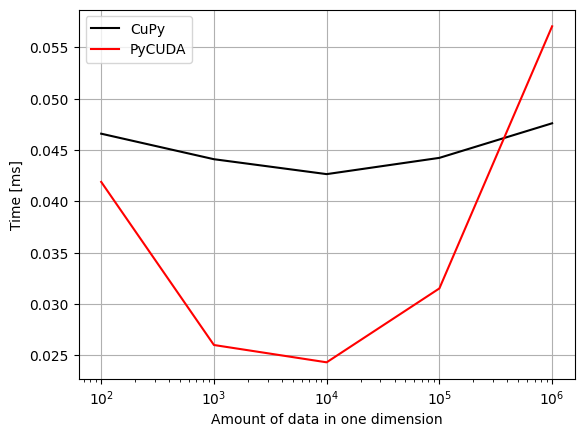

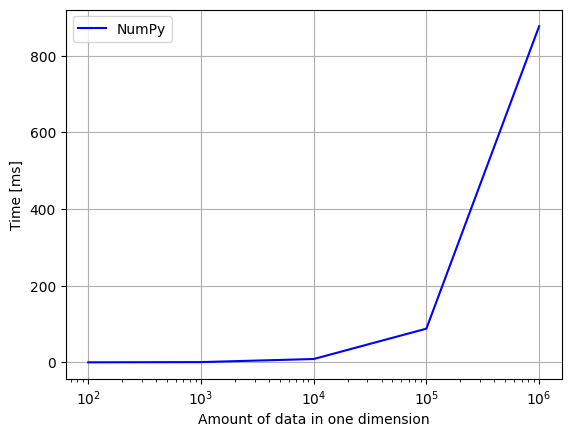

In [135]:
plt.xscale( "log" )
plt.plot( N_elems, times_cupy, 'k', label = "CuPy")
plt.plot( N_elems, times_kernel, 'r', label = "PyCUDA")

plt.xlabel( 'Amount of data in one dimension' )
plt.ylabel( 'Time [ms]' )
plt.legend( loc = "upper left" )
plt.grid()

plt.show()

# NumPy in its own figure because the results are so much "worse"
plt.xscale( "log" )
plt.plot( N_elems, times_numpy, 'b', label = "NumPy" )
plt.xlabel( 'Amount of data in one dimension' )
plt.ylabel( 'Time [ms]' )
plt.legend( loc = "upper left" )
plt.grid()